# Fascin Study

## PCA Plot

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/matplotlib/patches.py:1638: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  center = (self.convert_xunits(self._center[0]),
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/matplotlib/patches.py:1639: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self.convert_yunits(self._center[1]))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/matplotlib/patches.py:1638: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always 

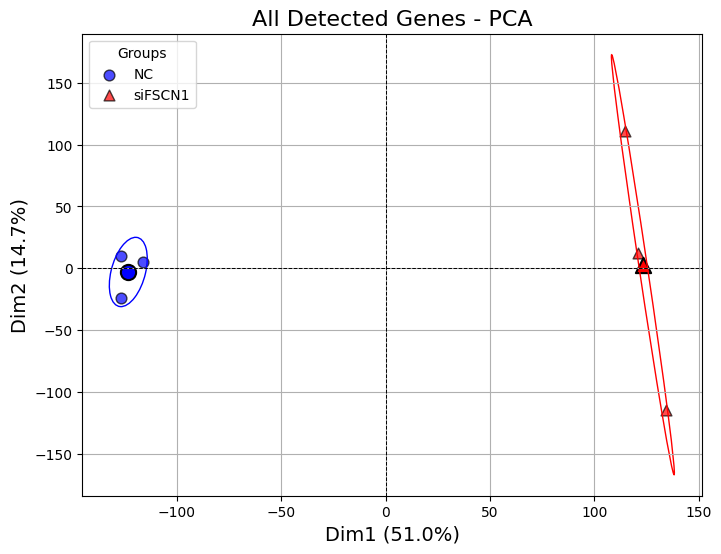

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib.patches import Ellipse

# Use only the first 6 columns because the rest are not FPKM values
fpkm = pd.read_csv("Data/GSE234859_expressed_gene_FPKM.txt",sep="\t",index_col=0,usecols=range(7))

# Creating a metadata for plotting and for differentail expression analysis later 
metadata = pd.DataFrame({
    "Groups": ["NC"] * 3 + ["siFSCN1"] * 3, 
    "replicate": ["R1", "R2", "R3", "R1", "R2", "R3"]
}, index=fpkm.columns)

# Using stnadardscaler to standardize the data, transformer used is not indicated in paper therefore the most common one was used 
scaler = StandardScaler()
scaled_fpkm = scaler.fit_transform(fpkm.T)
# Run pca here 
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_fpkm)

# Converting the pca results array to a dataframe for easier manipulation
pca_df = pd.DataFrame(pca_result, columns=["PC1", "PC2"], index=fpkm.columns)

# Plotting code
plt.figure(figsize=(8, 6))
groups = metadata["Groups"]
colors = {"NC": "blue", "siFSCN1": "red"}
markers = {"NC": "o", "siFSCN1": "^"}

# Scatter plot for PCA, looped through each condition based on the metadata
for condition in groups.unique():
    condition_data = pca_df[groups == condition]
    plt.scatter(condition_data["PC1"],condition_data["PC2"],label=condition,color=colors[condition],marker=markers[condition],s=60,edgecolor='black',alpha=0.7)
    # Calculating the mean of the groups 
    mean_point = condition_data.mean(axis=0)
    plt.scatter(mean_point["PC1"],mean_point["PC2"],color=colors[condition],marker=markers[condition],s=120,edgecolor="black",linewidth=1.5,alpha=1.0,label='_nolegend_' )
    # Code for adding ellipses around the points for each group 
    cov = np.cov(condition_data.T)
    eigenvalues, eigenvectors = np.linalg.eigh(cov)
    order = eigenvalues.argsort()[::-1]
    eigenvalues, eigenvectors = eigenvalues[order], eigenvectors[:, order]
    angle = np.arctan2(*eigenvectors[:, 0][::-1])
    angle = np.degrees(angle)
    width, height = 2 * np.sqrt(eigenvalues) * 1.5
    ellipse = Ellipse(xy=condition_data.mean(axis=0),width=width,height=height,angle=angle,color=colors[condition],fill=False,linestyle='-')
    plt.gca().add_patch(ellipse)

plt.title("All Detected Genes - PCA", fontsize=16)
plt.xlabel("Dim1 (" + str(round(pca.explained_variance_ratio_[0] * 100, 0)) + "%)",fontsize=14)
plt.ylabel("Dim2 (" + str(round(pca.explained_variance_ratio_[1] * 100, 1)) + "%)",fontsize=14)
plt.axhline(0,color="black",linestyle="--",linewidth=0.7)
plt.axvline(0,color="black",linestyle="--",linewidth=0.7)
plt.legend(title="Groups",loc="upper left")
plt.grid(True)
plt.show()

## Volcano Plot

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


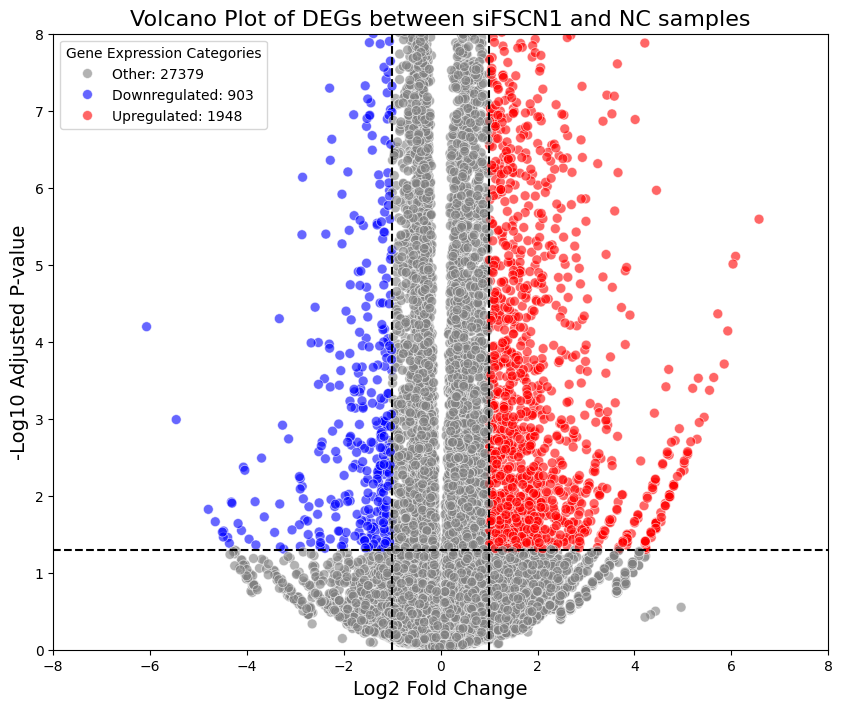

In [23]:
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr
import seaborn as sns

# Activating pandas2ri and importing required R packages 
pandas2ri.activate()
deseq2 = importr("DESeq2")
base = importr("base")
# Reading in count data
counts = pd.read_csv("Data/GSE234859_expressed_gene_reads.txt", sep="\t", index_col=0)
counts = counts.iloc[:,:6] 

# Convert to R objects, both count data and previously defined metadata 
r_counts = pandas2ri.py2rpy(counts)
r_metadata = pandas2ri.py2rpy(metadata)

# Create DESeq2 object and run DE analysis 
dds = deseq2.DESeqDataSetFromMatrix(countData=r_counts,colData=r_metadata,design=ro.Formula("~ Groups"))
dds = deseq2.DESeq(dds)
res = deseq2.results(dds)

# Convert results back to a pandas DataFrame for plotting
# based.data_frame(res) converts R obj to dataframe, rx2 extracts the column, baesd.as_vector converts it to a vector 
log2fc = base.as_vector(base.data_frame(res).rx2('log2FoldChange'))
padj = base.as_vector(base.data_frame(res).rx2('padj'))
res_df = pd.DataFrame({
    'log2FoldChange': log2fc,
    'padj': padj
})
res_df['gene'] = counts.index

# Creating a new 'category' column and eparating these genes based on required threshold indicated by the study
# Then count the number of each group and creating a legend for plotting
res_df['category'] = 'Other'
res_df.loc[(res_df['log2FoldChange'] > 1) & (res_df['padj'] < 0.05), 'category'] = 'Upregulated'
res_df.loc[(res_df['log2FoldChange'] < -1) & (res_df['padj'] < 0.05), 'category'] = 'Downregulated'
upregulated_count = (res_df['category'] == 'Upregulated').sum()
downregulated_count = (res_df['category'] == 'Downregulated').sum()
other_count = (res_df['category'] == 'Other').sum()
legend_labels = [f"Upregulated: {upregulated_count}",f"Downregulated: {downregulated_count}",f"Other: {other_count}"]

# Plotting coce
plt.figure(figsize=(10, 8))
sns.scatterplot(data=res_df,x='log2FoldChange',y=-np.log10(res_df['padj']),hue='category',palette={"Upregulated": "red", "Downregulated": "blue", "Other": "gray"},alpha=0.6,s=50)
# Adding the threshold lines and labels
plt.axhline(y=-np.log10(0.05), color='black', linestyle='--', label=None)
plt.axvline(x=1, color='black', linestyle='--', label=None)
plt.axvline(x=-1, color='black', linestyle='--', label=None)
plt.xlabel("Log2 Fold Change", fontsize=14)
plt.ylabel("-Log10 Adjusted P-value", fontsize=14)
plt.title("Volcano Plot of DEGs between siFSCN1 and NC samples", fontsize=16)
# Setting the limit of the axis, comment this if want to see the full plot
plt.xlim(-8, 8)  
plt.ylim(0, 8)  
# Updating the legend text dynamically
handles, labels = plt.gca().get_legend_handles_labels()
updated_labels = [
    f"Upregulated: {upregulated_count}" if label == "Upregulated" else
    f"Downregulated: {downregulated_count}" if label == "Downregulated" else
    f"Other: {other_count}" if label == "Other" else label
    for label in labels
]
plt.legend(handles, updated_labels, title="Gene Expression Categories", loc="upper left")
plt.show()


Paper link:

Fascin actin-bundling protein 1 regulates non-small cell lung cancer progression by influencing the transcription and splicing of tumorigenesis-related genes